Contents:
1. Figure 4-A in MR-APSS paper: estimation of genetic correaltion
2. Figure 4-B in MR-APSS paper: estimation of C12
3. Figure 4-C in MR-APSS paper: Significant pairs identified by MR-APSS

In [235]:
## Traits infomation
# Traits (file names)
exps = c("T2D", "Urate", "HBP", "Angina", "CAD", "BMI", "Height_GIANT", "Height_UKB", "RA", "IBD", "CD",
         "ASD", "Anorexia", "Smoking", "Alcohol", "Daytime_Sleepiness", "Insomnia", "MDD", "SCZ", "AD",
         "Depression", "Neuroticism", "SWB", "NEB", "Income", "Intelligence")

outs =  exps

nexp = nout = length(exps)

# Traits (names show in figures)
Name.exps = c("T2D", "Urate", "HBP", "Angina", "CAD", "BMI", "Height (GIANT)", "Height (UKBB)", "RA", "IBD", "CD",
              "ASD", "Anorexia", "Smoking", "Alcohol", "Daytime sleepiness", "Insomnia", "MDD", "SCZ", "AD", 
              "Depression", "Neuroticism", "SWB", "NEB", "Income", "Intelligence")

Name.outs = Name.exps

# Traits (group infomation)
TraitsInfo = read.csv("GWAS_26and5_source.csv", header = T)
TraitsInfo = TraitsInfo[, c("Filename","Trait","Group")]
TraitsInfo$Group = factor(as.character(TraitsInfo$Group), 
                          levels =c("Negative control outcome", "Cardiometabolic", "Anthropometric", 
                                    "Immune", "Neurological/Psychiatric", "Social"))

TraitsInfo.exps =  TraitsInfo
colnames(TraitsInfo.exps) = c("exposure","Name.exp","Group.exp")

TraitsInfo.outs =  TraitsInfo
colnames(TraitsInfo.outs) = c("outcome","Name.out","Group.out")

pairs = merge(TraitsInfo.exps, TraitsInfo.outs)
pairs = subset(pairs,  exposure!=outcome & 
                       Group.exp != "Negative control outcome" &
                       Group.out != "Negative control outcome")
npairs = nrow(pairs)


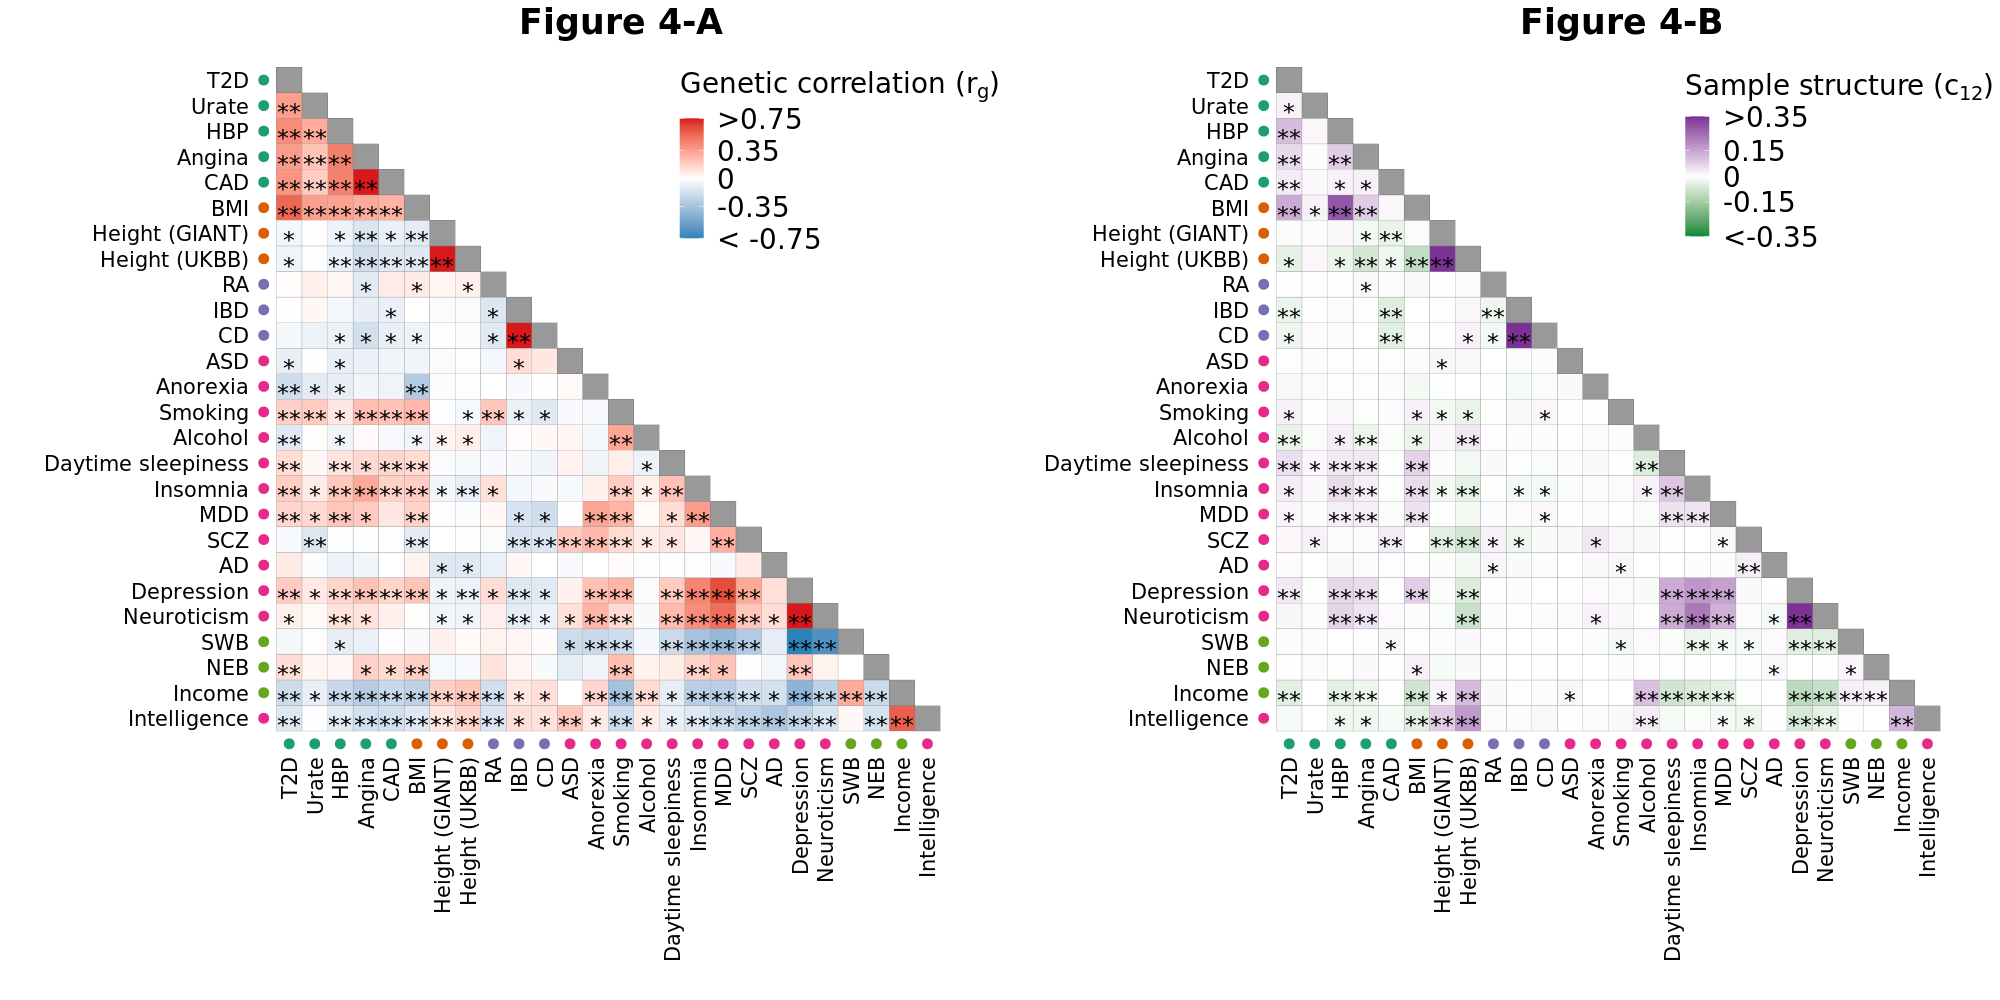

In [236]:
# estimation of genetic correaltion and C12
rgT= 0.75
library(ggplot2)
library(gridExtra)
library(ggpubr)
library(grid)
library(latex2exp)
library(ggnewscale)
TraitsInfo.exps = TraitsInfo.exps[match(exps, TraitsInfo.exps$exposure), ]
TraitsInfo.outs = TraitsInfo.outs[match(outs, TraitsInfo.outs$outcome), ]

diagonal = data.frame(Name.exp = 1:nexp,
                      Name.out = 1:nout )

traits.group = rbind(data.frame(Name.exp = 1:nexp,
                            Name.out = nout+1,
                            Group = TraitsInfo.exps$Group.exp),
                 data.frame(Name.exp = 0,
                            Name.out = 1:nout ,
                            Group = TraitsInfo.outs$Group.out))

traits.group$Group = factor(traits.group$Group, levels = unique(traits.group$Group))

## Reading in results 
ldsc_res =read.table("pairs_ldsc_res", header=T)
ldsc_res = ldsc_res[, c("exposure","outcome","rg","rg.se","C1","C2","C12","C12.se")]
ldsc_res$rg.pval = pchisq(ldsc_res$rg^2/ldsc_res$rg.se^2, 1, lower.tail = F)
ldsc_res$C12.pval = pchisq(ldsc_res$C12^2/ldsc_res$C12.se^2, 1, lower.tail = F)

ldsc_res = merge(ldsc_res, TraitsInfo.exps, by=c("exposure"))
ldsc_res = merge(ldsc_res, TraitsInfo.outs, by=c("outcome"))

pairs1 = data.frame(Name.exp = as.character(unlist(combn(Name.exps,2))[1,]),
                    Name.out =  as.character(unlist(combn(Name.exps,2))[2,]))

upper.tri = merge(ldsc_res, pairs1, by = c("Name.exp", "Name.out"))
upper.tri$Name.exp = as.numeric(factor(upper.tri$Name.exp, levels = Name.exps))
upper.tri$Name.out = as.numeric(factor(upper.tri$Name.out, levels = Name.outs))
upper.tri$rg = ifelse(abs(upper.tri$rg) <= 0.75, upper.tri$rg, sign(upper.tri$rg) * 0.75)
upper.tri$C12 = ifelse(abs(upper.tri$C12) <= 0.35, upper.tri$C12, sign(upper.tri$C12) * 0.35)

plot.rg = ggplot() +
  geom_tile(data = upper.tri, 
            aes(y = Name.out, x=Name.exp, fill = rg), color = "gray60") +
  geom_tile(data =  traits.group, 
            aes(y = Name.out, x=Name.exp), fill = "white",color = "gray60") +
  geom_point(dat = traits.group,
             aes(y = Name.out, x=Name.exp, color = Group), size=3) +
  geom_tile(data =  diagonal, 
            aes(y = Name.out, x=Name.exp), fill = "gray60",color = "gray40") +
  geom_text(data = subset(upper.tri, rg.pval <= 0.05 & rg.pval > 0.05/nrow(pairs1)), 
            aes(y = Name.out+0.25, x=Name.exp), label = "*", size = 6, color = "black")+
  geom_text(data = subset(upper.tri, rg.pval <= 0.05/nrow(pairs1)), 
            aes(y = Name.out+0.25, x=Name.exp), label = "**", size = 6, color = "black")+
scale_fill_gradient2(low = "#2b83ba", high = "#d7191c", mid = "white",
                     midpoint = 0, limit = c(-0.75,0.75),
                     breaks = c(0.75, 0.35, 0, -0.35, -0.75),
                     labels = c(">0.75", "0.35", "0", "-0.35", "< -0.75"),
                     space = "Lab",
                     name= TeX("Genetic correlation ($r_g$)")) +
scale_color_brewer( palette = "Dark2", name="Catergory") +
  guides(
    color = "none"
  ) +
 scale_y_reverse( limits = c((nout+1),0),
                        breaks = nout:1,
                      labels = rev(Name.outs)) +
  scale_x_continuous(limits = c(0,nexp+1),
                     breaks = 1:nexp,
                     labels = Name.exps) +
  labs(x="", y="") +
  theme(axis.text.x = element_text(angle = 90,vjust=0.5,hjust=1,
                                  size = 15, color = "black"),
        axis.text.y = element_text(size = 15, color = "black"),
        axis.ticks = element_blank(),
        axis.title = element_text(size = 20),
        legend.position = c(0.8,0.85),
        legend.text = element_text(size = 20),
        legend.title = element_text(size = 20),
        plot.title = element_text(hjust=0.5, size = 25, face = "bold"),
        panel.background=element_blank()) +
  coord_fixed(ylim =  c(nout,1), xlim= c(1, nexp+1), ratio=1) 


plot.c12 = ggplot() +
  geom_tile(data = upper.tri, 
            aes(y = Name.out, x=Name.exp, fill = C12), color = "gray60") +
  scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", 
                       midpoint = 0, limit = c(-0.35,0.35),
                       breaks = c( 0.35,0.15, 0, -0.15, -0.35),
                       labels = c( ">0.35","0.15", "0", "-0.15", "<-0.35"),
                       space = "Lab", 
                       name= TeX("Sample structure ($c_{12}$)")) +
  geom_tile(data =  ts.group, 
            aes(y = Name.out, x=Name.exp), fill = "white",color = "gray60") +
  geom_point(dat = ts.group,
             aes(y = Name.out, x=Name.exp, color = Group), size=3) +
  geom_tile(data =  diagonal, 
            aes(y = Name.out, x=Name.exp), fill = "gray60",color = "gray40") +
  geom_text(data = subset(upper.tri, C12.pval <= 0.05 & C12.pval > 0.05/nrow(pairs1)), 
            aes(y = Name.out+0.25, x=Name.exp), label = "*", size = 6, color = "black")+
  geom_text(data = subset(upper.tri, C12.pval <= 0.05/nrow(pairs1)), 
            aes(y = Name.out+0.25, x=Name.exp), label = "**", size = 6, color = "black")+
  scale_color_brewer( palette = "Dark2", name="Catergory") +
  guides(color = "none") +
  scale_y_reverse( limits = c((nout+1),0),
                        breaks = nout:1,
                      labels = rev(Name.outs)) +
  scale_x_continuous(limits = c(0,nexp+1),
                     breaks = 1:nexp,
                     labels = Name.exps) +
  labs(x="", y="") +
  theme(axis.text.x = element_text(angle = 90,vjust=0.5,hjust=1,
                                  size = 15, color = "black"),
        axis.text.y = element_text(size = 15, color = "black"),
        axis.ticks = element_blank(),
        axis.title = element_text(size = 20),
        legend.position = c(0.8,0.85),
        legend.text = element_text(size = 20),
        legend.title = element_text(size = 20),
        plot.title = element_text(hjust=0.5, size = 25, face = "bold"),
        panel.background=element_blank()) +
  coord_fixed(ylim =  c(nout,1), xlim= c(1, nexp+1), ratio=1) 

options(repr.plot.width = 20, repr.plot.height = 10, repr.plot.res = 100)  
grid.arrange(plot.rg+ ggtitle("Figure 4-A"), plot.c12 + ggtitle("Figure 4-B"), 
             layout_matrix = matrix(c(1,2), ncol =2, byrow = T))

In [237]:
options(repr.plot.width = 15, repr.plot.height = 12, repr.plot.res = 100)  

## Results of MR methods
apss_res = read.table("Traits_MRAPSS.MRres", header = T)

## Function for plotting significant pairs identified by one specified MR method
plot.MR <- function(MRres, method){
    
    dat = subset(MRres, Method == method)
    dat = merge(dat, ldsc_res, by = c("exposure", "outcome"), all.y = T)
    
    dat$Name.exp = as.numeric(factor(dat$Name.exp, levels = as.character(Name.exps)))
    dat$Name.out = as.numeric(factor(dat$Name.out, levels = as.character(Name.outs)))
 
    dat$shape =  ifelse(dat$beta.hat < 0, "-1", "1")
    
    ggplot() +
    geom_tile(data =  subset(dat, abs(rg) >= rgT), aes(y = Name.out, x=Name.exp), fill="gray60", color = "gray40") +
    geom_tile(data = subset(dat, abs(rg) < rgT), aes(y = Name.out, x=Name.exp), fill="white", color = "gray40") +
    geom_point(data = subset(dat, is.na(dat$beta.hat)), aes(y = Name.out, x=Name.exp), shape = 4, fill="white",
               color = "gray40") +
    geom_tile(data =  traits.group, aes(y = Name.out, x=Name.exp), fill = "white")+
    geom_point(data= subset(dat, pval < 0.05/npairs), aes(y = Name.out, x=Name.exp, shape = shape,color = shape), 
               stroke=0.5,size = 6) +
    scale_shape_manual(breaks = c("-1","1"),values=c("\u25BC", "\u25B2"), 
                     labels=c("-","+"), name="Effect direction") +
    scale_color_manual(breaks = c("-1","1"), values = c("-1"="#377EB8","1"="#E41A1C"),
                     labels=c("-","+"), name="Effect direction") +
    ggnewscale::new_scale_color() +
    geom_tile(data =  subset(dat, abs(rg)>=rgT), aes(y = Name.out, x=Name.exp), fill = "gray60",color = "gray40") +
    geom_tile(data =  diagonal, aes(y = Name.out, x=Name.exp), fill = "gray60",color = "gray40") +
    geom_point(dat = traits.group, aes(y = Name.out, x=Name.exp, color = Group), size=3, fill = "white") +
    scale_color_brewer( palette = "Dark2")+
    scale_y_reverse(limits = c((nout+1),0), breaks = nout:1, labels = rev(Name.outs)) +
    scale_x_continuous(limits = c(0,nexp+1),breaks = 1:nexp, labels = Name.exps) +
    labs(x="Exposure", y="Outcome", title=method) +
    theme(axis.text.x = element_text(angle = 90,vjust=0.5,hjust=1, size = 15, color = "black"),
          axis.text.y = element_text(size = 15, hjust=1.05, color = "black"),
          axis.ticks = element_blank(),
          axis.title = element_text(size = 20),
          legend.text = element_text(size = 20),
          legend.title = element_text(size = 20),
          legend.position = "right",
          plot.title = element_text(hjust=0.5, size = 25, face = "bold"),
          panel.background=element_blank()) +
    coord_fixed(ylim = c(nout-0.5,1), xlim= c(1, nexp+1), ratio=1) 

}


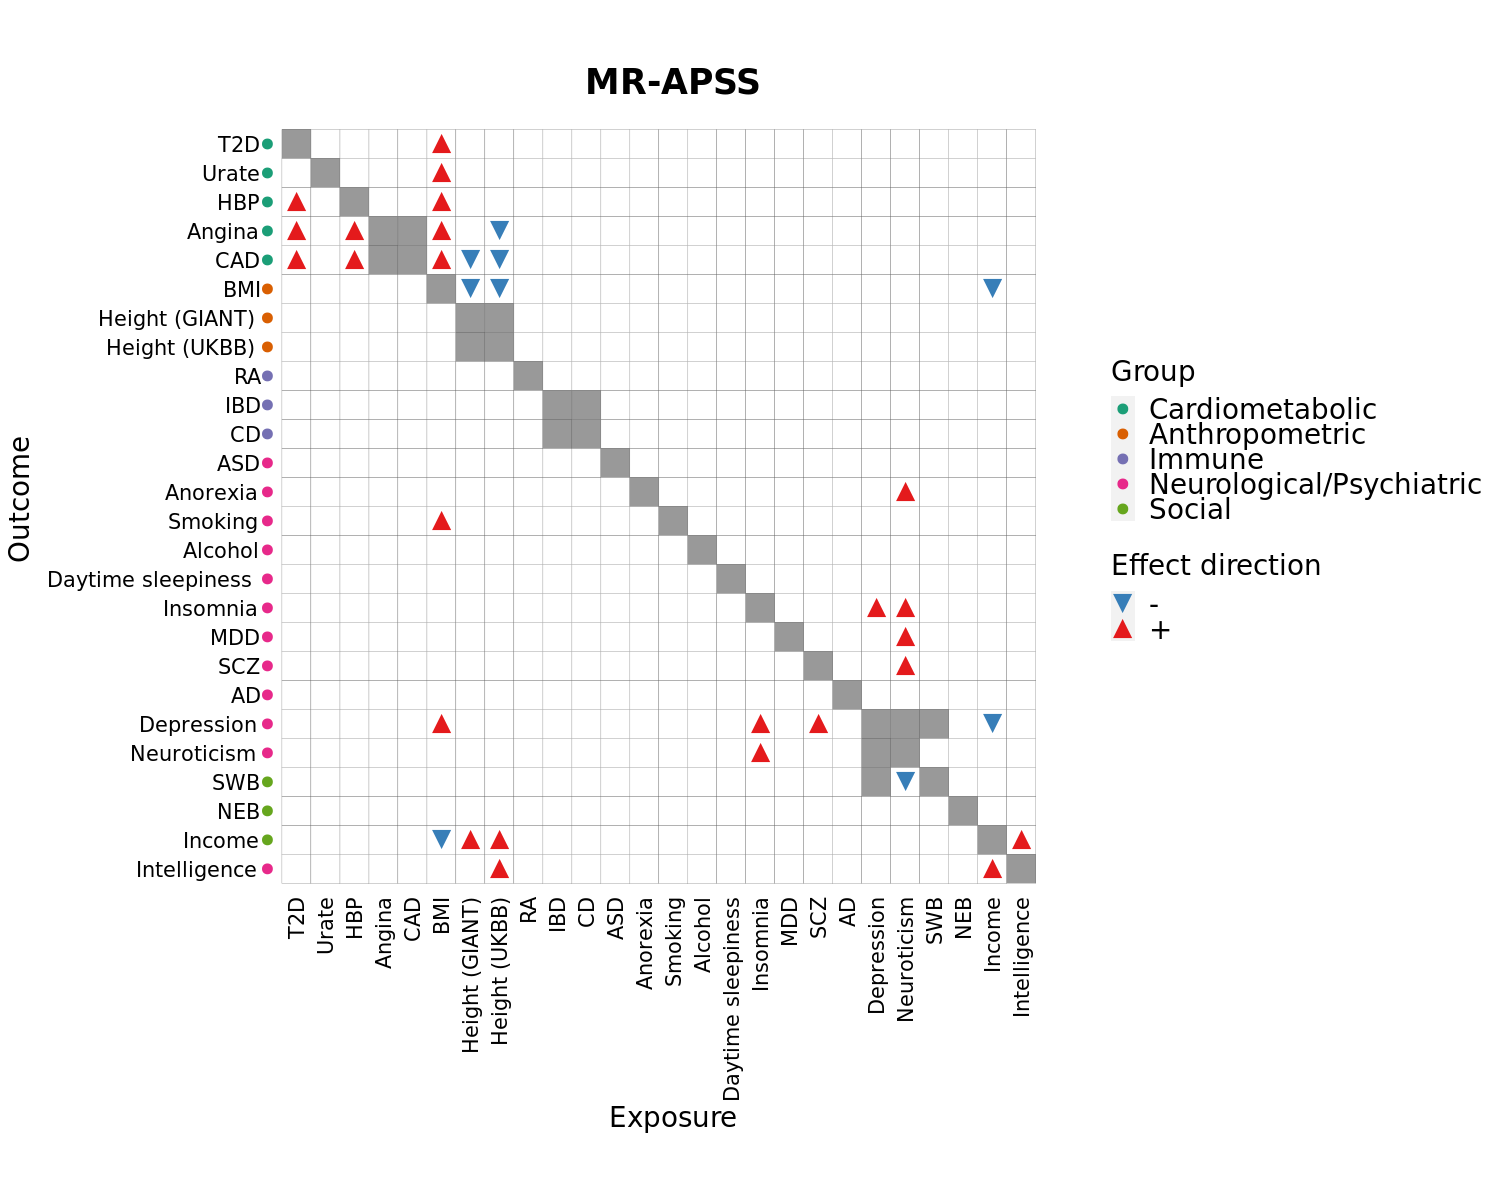

In [238]:
plot.MR(MRres=apss_res, "MR-APSS")